In [1]:
!pip install transformers==3.0.2
!pip install datasets==1.2.0

     |████████████████████████████████| 769 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 13.8 MB/s eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.2
    Uninstalling tokenizers-0.10.2:
      Successfully uninstalled tokenizers-0.10.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.3.0 requires transformers<4.6,>=4.1, but you have transformers 3.0.2 which is incompatible.
     |████████████████████████████████| 159 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 4.5 MB/s  eta 0:00:01
  Attempting uninstall: tqdm
    

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

SEED = 13
tf.random.set_seed(SEED)
np.random.seed(SEED)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if (tpu):
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

n_replica = strategy.num_replicas_in_sync
print("REPLICAS: ", n_replica)

if (n_replica <= 1):
    print('WARNING! Gradients are not calculated distributedly on TPUs.')
    print('This will take almost forever until we finish.')
else:
    print("We're gonna get this thing done pretty fast.")
print("That's what she said.")

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
We're gonna get this thing done pretty fast.
That's what she said.


In [4]:
train_data = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test_data = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')

# train_data = pd.read_csv('/content/train.csv')
# test_data = pd.read_csv('/content/test.csv')

In [5]:
train_data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
train_data['language'].value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

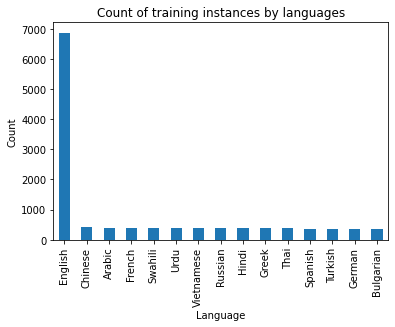

In [7]:
train_data['language'].value_counts().plot(kind='bar')
plt.title('Count of training instances by languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

In [8]:
xnli_th_data = load_dataset('xnli', 'th')

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/th/1.1.0/51ba3a1091acf33fd7c2a54bcbeeee1b1df3ecb127fdca003d31968fa3a1e6a8. Subsequent calls will reuse this data.


In [9]:
xnli_th_data_dict = dict()
for dataset in xnli_th_data:
    instance_dict_list = list()
    for instance in xnli_th_data[dataset]:
        instance_dict_list.append(instance)
    xnli_th_data_dict[dataset] = pd.DataFrame(instance_dict_list)[['premise', 'hypothesis', 'label']]

In [10]:
for df in xnli_th_data_dict:
    print(df, xnli_th_data_dict[df].shape)
    display(xnli_th_data_dict[df].head())

train (392702, 3)


,premise,hypothesis,label
0,ท่า ครีม ยักยอก มี สอง มิติ พื้นฐาน - สินค...,สินค้า และ ภูมิศาสตร์ คือ สิ่ง ที่ ทำให้ ครีม ...,1
1,คุณ รู้ ว่า ใน ช่วง ฤดูกาล และ ฉัน เดา ว่า ใน ...,คุณ สูญเสีย สิ่ง ต่างๆ ไป ใน ระดับ ต่อไปนี้ หา...,0
2,หนึ่ง ใน หมายเลข ของ เรา จะ ดำเนินการ ให้ คำแน...,สมาชิก ใน ทีม ของ ฉัน จะ ทำ ตามคำสั่ง ของ คุณ ...,0
3,รุ้ ได้ ไง ทั้งหมด นี้ คือ ข้อมูล ของ พวกเขา อ...,ข้อมูล นี้ เป็น ของ พวกเขา,0
4,ใช่ ฉัน จะ บอก คุณ ว่า ถ้า คุณ ไป ราคา บางส่วน...,รองเท้า เทนนิส มี ช่วง ของ ราคา,1


test (5010, 3)


,premise,hypothesis,label
0,"ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...",ฉันไม่ได้คุยกับเขาอีกเลย,2
1,"ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...",ฉันรู้สึกเเย่มากที่ฉันกำลังเริ่มที่จะคุยกับเขา...,0
2,"ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...",พวกเราคุยกันได้ถูกคอจริงๆ,1
3,และฉันนึกว่านั้นเป็นสิทธิพิเศษและมันยังคงเป็น ...,ฉันไม่รู้เลยว่าฉันไม่ใช่เเค่คนเดียวที่อยู่ที่ไ...,1
4,และฉันนึกว่านั้นเป็นสิทธิพิเศษและมันยังคงเป็น ...,ฉันเข้าใจว่าฉันคือคนเดียวที่มีเลขที่ AFFC สาขา...,0


validation (2490, 3)


,premise,hypothesis,label
0,"และเขาพูดว่า, ม่าม๊า ผมอยู่บ้าน",เขาโทรหาเเม่ของเขาอย่างรวดเร็วหลังจากที่รถโรงเ...,1
1,"และเขาพูดว่า, ม่าม๊า ผมอยู่บ้าน",เขาไม่ได้พูดสักคำ,2
2,"และเขาพูดว่า, ม่าม๊า ผมอยู่บ้าน",เขาบอกเเม่เขาว่าเขาถึงบ้านเเล้ว,0
3,ฉันไม่รู้ว่าฉันไปเพื่ออะไรหรือเพื่อสิ่งใด ดังน...,ฉันไม่เคยไป กรุงวอชิงตันมาก่อนเลย เพราะเช่นนั้...,1
4,ฉันไม่รู้ว่าฉันไปเพื่ออะไรหรือเพื่อสิ่งใด ดังน...,ฉันรู้อยู่เเล้วว่าฉันจะต้องทำยังไงจะปรับตัวกับ...,2


In [11]:
TEST_SIZE = 0.25

X_train_df, X_val_df , y_train_ser, y_val_ser = train_test_split(train_data[['premise', 'hypothesis']], train_data['label'], test_size=TEST_SIZE, random_state=SEED)

In [12]:
all_train_df = X_train_df
all_train_df['label'] = y_train_ser
all_train_df = all_train_df.append(xnli_th_data_dict['validation'])
all_train_df = all_train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
all_train_df.head()

,premise,hypothesis,label
0,สหรัฐฯเคยปกป้องและยังคงปกป้องชาวมุสลิมจากเหล่า...,ชาวมุสลิมในโซมาเลียบางครั้งถูกคุกคามโดยเผด็จการ,0
1,uh right now we're actually having uh it's get...,Temperatures are still below the freezing poin...,2
2,"I see, said Tuppence thoughtfully.","""I understand,"" said Tuppence after taking a q...",1
3,well that's pretty typical though uh i don't u...,It's pretty normal to have a few hundred degre...,0
4,"ภรรยาของฉันพูดว่า, ขยักคิ้วขึ้น",ภรรยาของตาเหล่ขณะที่เธอพูด,2


In [13]:
X_train = all_train_df[['premise', 'hypothesis']].values.tolist()
y_train = all_train_df['label'].values

X_val = X_val_df.values.tolist()
y_val = y_val_ser.values

In [14]:
XLM_ROBERTA_PATH = 'joeddav/xlm-roberta-large-xnli'

tokenizer = AutoTokenizer.from_pretrained(XLM_ROBERTA_PATH, use_fast=False) # default (True) now return XLMRobertaTokenizerFast

In [15]:
MAX_SENTENCE_LEN = 120

def tokenize_sentence(text, tokenizer):
    encoded_sentences = tokenizer(text, 
                                    padding='max_length', 
                                    max_length=MAX_SENTENCE_LEN, 
                                    truncation=True)
    return np.array(encoded_sentences['input_ids'])

In [16]:
X_train_tokenized = tokenize_sentence(X_train, tokenizer)
X_val_tokenized = tokenize_sentence(X_val, tokenizer)

In [17]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

try:
    prefetch_buffer_size = tf.data.AUTOTUNE # tensorflow 2.4 on default gcolab
except:
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE # tensorflow 2.2.0 on default kaggle
else:
    prefetch_buffer_size = BATCH_SIZE # if fail then just fetch what ever you got next

def build_dataset(x, y, mode, batch_size, prefetch_buffer_size, shuffle_buffer_size=None):
    if mode == "train":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .shuffle(buffer_size=shuffle_buffer_size, seed=SEED) # Shuffle in the buffer for ultimate joy only. Actually pointless in this case.
            .repeat() # count=None to iterate indefinitely
            .batch(batch_size) # output as batch for each step
            .prefetch(prefetch_buffer_size) # prefetch for faster pipeline
        )
    elif mode == "valid":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .batch(batch_size)
            .prefetch(prefetch_buffer_size)
        )
    elif mode == "test":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices(x)
            .batch(batch_size)
            .prefetch(prefetch_buffer_size)
        )
    else:
        print('STOP! What are you doing, step-user?')
        raise NotImplementedError
    return dataset

In [18]:
train_dataset = build_dataset(X_train_tokenized, y_train, "train",
                              batch_size=BATCH_SIZE,
                              prefetch_buffer_size=prefetch_buffer_size,
                              shuffle_buffer_size=len(X_train_tokenized))

valid_dataset = build_dataset(X_val_tokenized, y_val, "valid",
                              batch_size=BATCH_SIZE,
                              prefetch_buffer_size=prefetch_buffer_size)

In [19]:
def chain_compile_transformer(transformer_model, learning_rate):
    # chain them up
    input_ids = keras.Input(shape=(MAX_SENTENCE_LEN,), dtype=tf.int32)
    transformer_model = transformer_model([input_ids])[0]
    transformer_model = keras.layers.GlobalAveragePooling1D()(transformer_model)
    outputs = keras.layers.Dense(3, activation='softmax')(transformer_model)

    my_model = keras.Model(inputs=input_ids, outputs=outputs)
    my_model.layers[1].layers[0].trainable = False
    
    my_model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])
    return my_model

def create_transformer_model(transformer_path, learning_rate):
    keras.backend.clear_session()
    with strategy.scope():
        transformer_model = TFAutoModel.from_pretrained(transformer_path)
        model = chain_compile_transformer(transformer_model, learning_rate)
    
    model.summary()
    return model

In [20]:
my_xlm = create_transformer_model(XLM_ROBERTA_PATH, 1e-5)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 120, 1024), (None 559890432 
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 3,075
Non-trainable params: 559,890,432
_________________________________________________________________


In [21]:
def fit_model(model, train_dataset, valid_dataset, steps_per_epoch, epochs, additional_callbacks=None):
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=epochs,
                                                restore_best_weights=True)
                ]
    if (not (additional_callbacks is None)):
        callbacks = callbacks + additional_callbacks
    
    model_history = model.fit(train_dataset,
                                validation_data=valid_dataset,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs, 
                                callbacks=callbacks)
    return model_history

In [22]:
epochs = 20
steps_per_epoch = len(X_train) // BATCH_SIZE

my_xlm_history = fit_model(my_xlm, train_dataset, valid_dataset, steps_per_epoch, epochs)

Epoch 1/20
90/90 [==============================] - 80s 387ms/step - loss: 1.9293 - accuracy: 0.2903 - val_loss: 1.9203 - val_accuracy: 0.2746
Epoch 2/20
90/90 [==============================] - 7s 83ms/step - loss: 1.6323 - accuracy: 0.2941 - val_loss: 1.6420 - val_accuracy: 0.2825
Epoch 3/20
90/90 [==============================] - 8s 84ms/step - loss: 1.3978 - accuracy: 0.3046 - val_loss: 1.4045 - val_accuracy: 0.2931
Epoch 4/20
90/90 [==============================] - 8s 85ms/step - loss: 1.2132 - accuracy: 0.3496 - val_loss: 1.2041 - val_accuracy: 0.3719
Epoch 5/20
90/90 [==============================] - 8s 84ms/step - loss: 1.0546 - accuracy: 0.4898 - val_loss: 1.0385 - val_accuracy: 0.5106
Epoch 6/20
90/90 [==============================] - 8s 84ms/step - loss: 0.9386 - accuracy: 0.5661 - val_loss: 0.9024 - val_accuracy: 0.5927
Epoch 7/20
90/90 [==============================] - 8s 84ms/step - loss: 0.8395 - accuracy: 0.6249 - val_loss: 0.7904 - val_accuracy: 0.6502
Epoch 8/20


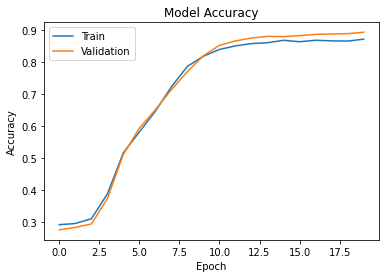

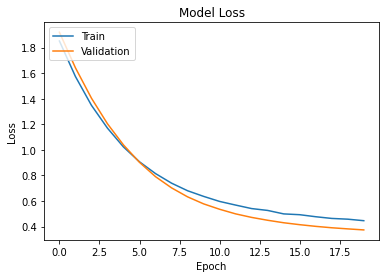

In [23]:
# Accuracy
plt.plot(my_xlm_history.history['accuracy'])
plt.plot(my_xlm_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# loss
plt.plot(my_xlm_history.history['loss'])
plt.plot(my_xlm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

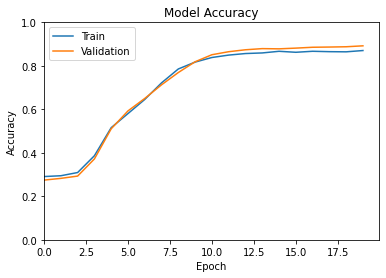

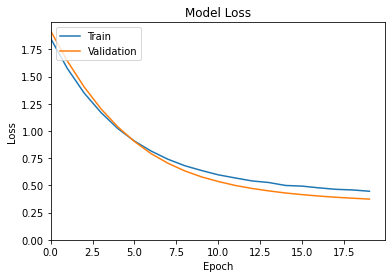

In [24]:
# Accuracy
plt.plot(my_xlm_history.history['accuracy'])
plt.plot(my_xlm_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0)
plt.show()

# loss
plt.plot(my_xlm_history.history['loss'])
plt.plot(my_xlm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()

In [25]:
def unfreeze_model(model, learning_rate):
    model.layers[1].layers[0].trainable = True
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), 
                            loss='sparse_categorical_crossentropy', 
                            metrics=['accuracy'])
    
    model.summary()
    return model

In [26]:
my_xlm = unfreeze_model(my_xlm, 1e-5)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 120, 1024), (None 559890432 
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


In [27]:
epochs = 5
steps_per_epoch = len(X_train) // BATCH_SIZE

my_xlm_history = fit_model(my_xlm, train_dataset, valid_dataset, steps_per_epoch, epochs)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


90/90 [==============================] - 203s 655ms/step - loss: 0.3056 - accuracy: 0.8941 - val_loss: 0.2125 - val_accuracy: 0.9304
Epoch 2/5
90/90 [==============================] - 25s 280ms/step - loss: 0.1349 - accuracy: 0.9553 - val_loss: 0.2221 - val_accuracy: 0.9320
Epoch 3/5
90/90 [==============================] - 25s 280ms/step - loss: 0.0966 - accuracy: 0.9672 - val_loss: 0.2848 - val_accuracy: 0.9264
Epoch 4/5
90/90 [==============================] - 25s 281ms/step - loss: 0.0522 - accuracy: 0.9840 - val_loss: 0.3214 - val_accuracy: 0.9290
Epoch 5/5
90/90 [==============================] - 25s 280ms/step - loss: 0.0449 - accuracy: 0.9859 - val_loss: 0.3057 - val_accuracy: 0.9327


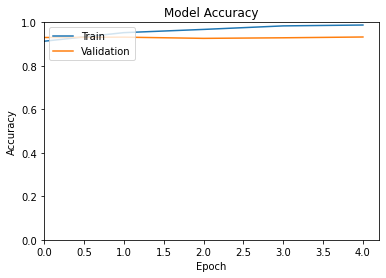

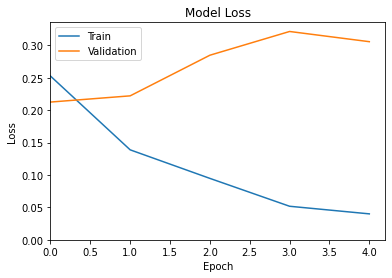

In [28]:
# Accuracy
plt.plot(my_xlm_history.history['accuracy'])
plt.plot(my_xlm_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0)
plt.show()

# loss
plt.plot(my_xlm_history.history['loss'])
plt.plot(my_xlm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()

In [29]:
xnli_th_test = xnli_th_data_dict['test'].copy()
X_xnli_th_test = xnli_th_test[['premise', 'hypothesis']].values.tolist()
X_xnli_th_test_tokenized = tokenize_sentence(X_xnli_th_test, tokenizer)

xnli_th_test_pred_prob = my_xlm.predict(X_xnli_th_test_tokenized)
xnli_th_test['y_hat'] = np.argmax(xnli_th_test_pred_prob, axis=1)
display(xnli_th_test.head())

print(classification_report(xnli_th_test['label'], xnli_th_test['y_hat'], digits=5))

,premise,hypothesis,label,y_hat
0,"ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...",ฉันไม่ได้คุยกับเขาอีกเลย,2,2
1,"ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...",ฉันรู้สึกเเย่มากที่ฉันกำลังเริ่มที่จะคุยกับเขา...,0,0
2,"ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...",พวกเราคุยกันได้ถูกคอจริงๆ,1,1
3,และฉันนึกว่านั้นเป็นสิทธิพิเศษและมันยังคงเป็น ...,ฉันไม่รู้เลยว่าฉันไม่ใช่เเค่คนเดียวที่อยู่ที่ไ...,1,1
4,และฉันนึกว่านั้นเป็นสิทธิพิเศษและมันยังคงเป็น ...,ฉันเข้าใจว่าฉันคือคนเดียวที่มีเลขที่ AFFC สาขา...,0,0


              precision    recall  f1-score   support

           0    0.97865   0.98802   0.98331      1670
           1    0.98260   0.98084   0.98172      1670
           2    0.99095   0.98323   0.98708      1670

    accuracy                        0.98403      5010
   macro avg    0.98407   0.98403   0.98404      5010
weighted avg    0.98407   0.98403   0.98404      5010



In [30]:
X_test = test_data[['premise', 'hypothesis']].values.tolist()
X_test_tokenized = tokenize_sentence(X_test, tokenizer)

dear_watson_df = test_data[['id']].copy()
dear_watson_result = my_xlm.predict(X_test_tokenized)
dear_watson_df['prediction'] = np.argmax(dear_watson_result, axis = 1)
dear_watson_df

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0


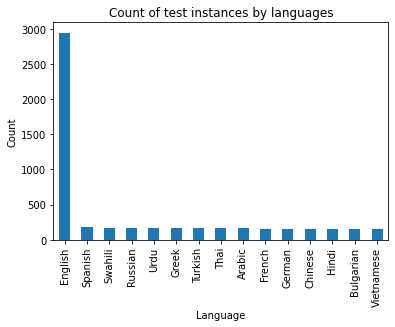

In [31]:
test_data['language'].value_counts().plot(kind='bar')
plt.title('Count of test instances by languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

In [32]:
def predict_and_print(premise, hypothesis, model):
    class_dict = {
        0: 'entailment',
        1: 'neutral',
        2: 'contradiction'
    }

    input_list = [[premise, hypothesis]]
    tokenized_input = tokenize_sentence(input_list, tokenizer)
    input_result = model.predict(tokenized_input)
    input_result_class = np.argmax(input_result)

    print(f'premise: {premise}')
    print(f'hypothesis: {hypothesis}')
    print(f'prediction: {class_dict[input_result_class]}')
    print('-'*40)

In [33]:
premise = 'เด็กหญิงมาลีถูกสอนให้กินข้าวจนหมด'
hypothesis = 'เด็กหญิงมาลีกินข้าวหมดจานเลยค่ะ'
predict_and_print(premise, hypothesis, my_xlm)

premise: เด็กหญิงมาลีถูกสอนให้กินข้าวจนหมด
hypothesis: เด็กหญิงมาลีกินข้าวหมดจานเลยค่ะ
prediction: entailment
----------------------------------------


In [48]:
premise = 'ไอ้โอม ไอ้โอม! ตาลือตกบ้าน!'
hypothesis = 'โอมว่าเผ่นเหอะพี่ บ้านนี้ผีดุ'
predict_and_print(premise, hypothesis, my_xlm)

premise: ไอ้โอม ไอ้โอม! ตาลือตกบ้าน!
hypothesis: โอมว่าเผ่นเหอะพี่ บ้านนี้ผีดุ
prediction: neutral
----------------------------------------


In [34]:
premise = 'ถ้าจำนวนเต็มใดหารด้วยสองลงตัวแล้วจำนวนเต็มนั้นเป็นจำนวนเต็มคู่ และจำนวนเต็มคี่คือจำนวนเต็มที่ไม่ใช่จำนวนเต็มคู่'
hypothesis = 'สิบสามเป็นจำนวนเต็มคี่เพราะหารด้วยสองไม่ลงตัว'
predict_and_print(premise, hypothesis, my_xlm)

premise: ถ้าจำนวนเต็มใดหารด้วยสองลงตัวแล้วจำนวนเต็มนั้นเป็นจำนวนเต็มคู่ และจำนวนเต็มคี่คือจำนวนเต็มที่ไม่ใช่จำนวนเต็มคู่
hypothesis: สิบสามเป็นจำนวนเต็มคี่เพราะหารด้วยสองไม่ลงตัว
prediction: neutral
----------------------------------------


In [35]:
premise = 'ได้ฮักกับอ้ายเหมือนใจได้ปริญญา ชีวิตผู้สาวบ้านนาวุฒิการศึกษามีน้อย ขาดโอกาสเรียนเพราะจนเป็นคนเลื่อนลอย โชคดีมีอ้ายเฝ้าคอยหยัดยืนให้โอกาสใจ'
hypothesis = 'เธอเรียนจบแล้ว'
predict_and_print(premise, hypothesis, my_xlm)

premise: ได้ฮักกับอ้ายเหมือนใจได้ปริญญา ชีวิตผู้สาวบ้านนาวุฒิการศึกษามีน้อย ขาดโอกาสเรียนเพราะจนเป็นคนเลื่อนลอย โชคดีมีอ้ายเฝ้าคอยหยัดยืนให้โอกาสใจ
hypothesis: เธอเรียนจบแล้ว
prediction: entailment
----------------------------------------


In [36]:
premise = 'ได้ฮักกับอ้ายก็ยังไม่ถึงกับได้ปริญญา ชีวิตผู้สาวบ้านนาวุฒิการศึกษามีน้อย ขาดโอกาสเรียนเพราะจนเป็นคนเลื่อนลอย โชคดีมีอ้ายเฝ้าคอยหยัดยืนให้โอกาสใจ'
hypothesis = 'เธอเรียนจบแล้ว'
predict_and_print(premise, hypothesis, my_xlm)

premise: ได้ฮักกับอ้ายก็ยังไม่ถึงกับได้ปริญญา ชีวิตผู้สาวบ้านนาวุฒิการศึกษามีน้อย ขาดโอกาสเรียนเพราะจนเป็นคนเลื่อนลอย โชคดีมีอ้ายเฝ้าคอยหยัดยืนให้โอกาสใจ
hypothesis: เธอเรียนจบแล้ว
prediction: contradiction
----------------------------------------


In [37]:
premise = 'ปัญหาเมื่อคืนนี้ทำให้พนักงานทุกคนต้องมารวมหัวกันแก้จนกระทั่งผ่านไปได้ด้วยดีก่อนที่พระอาทิตย์จะขึ้น'
hypothesis = 'เมื่อคืนไม่มีใครแม้แต่จะเหลียวมองปัญหาที่เกิดขึ้นเลย'
predict_and_print(premise, hypothesis, my_xlm)
    

premise = 'ปัญหาเมื่อคืนนี้ทำให้พนักงานทุกคนต้องมารวมหัวกันแก้จนกระทั่งผ่านไปได้ด้วยดีก่อนที่พระอาทิตย์จะขึ้น'
hypothesis = 'เมื่อคืนทุกคนสนใจปัญหาที่เกิดขึ้นกันมาก'
predict_and_print(premise, hypothesis, my_xlm)

premise: ปัญหาเมื่อคืนนี้ทำให้พนักงานทุกคนต้องมารวมหัวกันแก้จนกระทั่งผ่านไปได้ด้วยดีก่อนที่พระอาทิตย์จะขึ้น
hypothesis: เมื่อคืนไม่มีใครแม้แต่จะเหลียวมองปัญหาที่เกิดขึ้นเลย
prediction: contradiction
----------------------------------------
premise: ปัญหาเมื่อคืนนี้ทำให้พนักงานทุกคนต้องมารวมหัวกันแก้จนกระทั่งผ่านไปได้ด้วยดีก่อนที่พระอาทิตย์จะขึ้น
hypothesis: เมื่อคืนทุกคนสนใจปัญหาที่เกิดขึ้นกันมาก
prediction: entailment
----------------------------------------


In [38]:
premise = "Come up to meet you, tell you I'm sorry. You don't know how lovely you are"
hypothesis = "You're beautiful."
predict_and_print(premise, hypothesis, my_xlm)

premise: Come up to meet you, tell you I'm sorry. You don't know how lovely you are
hypothesis: You're beautiful.
prediction: entailment
----------------------------------------


In [39]:
premise = 'การทำรัฐประหารเป็นความผิดต่อแผ่นดิน'
hypothesis = 'การยึดอำนาจอธิปไตยนั้นเป็นเรื่องชอบธรรม'
predict_and_print(premise, hypothesis, my_xlm)

premise: การทำรัฐประหารเป็นความผิดต่อแผ่นดิน
hypothesis: การยึดอำนาจอธิปไตยนั้นเป็นเรื่องชอบธรรม
prediction: contradiction
----------------------------------------


In [40]:
premise = 'พี่แมนบอกเลิกแอนนี่เพราะว่าแอนนี่พูดไม่รู้เรื่อง'
hypothesis = 'แอนนี่ถูกพี่แมนทิ้งเพราะว่าเป็นคนเข้าใจยาก'
predict_and_print(premise, hypothesis, my_xlm)

premise: พี่แมนบอกเลิกแอนนี่เพราะว่าแอนนี่พูดไม่รู้เรื่อง
hypothesis: แอนนี่ถูกพี่แมนทิ้งเพราะว่าเป็นคนเข้าใจยาก
prediction: entailment
----------------------------------------


In [41]:
premise = 'พี่แมนบอกแอนนี่ว่าจะไปเที่ยวกับเพื่อนสมัยเด็กคืนนี้นะ'
hypothesis = 'พี่แมนมีคนอื่น'
predict_and_print(premise, hypothesis, my_xlm)

premise: พี่แมนบอกแอนนี่ว่าจะไปเที่ยวกับเพื่อนสมัยเด็กคืนนี้นะ
hypothesis: พี่แมนมีคนอื่น
prediction: entailment
----------------------------------------
